# Temporal and Spatial X-over

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#import scipy.stats
#import contextily as cx
#from matplotlib_scalebar.scalebar import ScaleBar
import rasterio as rio
#from rasterio import features
#from rasterio.plot import show
#import rioxarray
#from astropy.time import Time
from datetime import datetime
import pickle
from rasterio import features
import hvplot.pandas
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts

import contextily as cx
basemap = cx.providers.Stamen.Terrain
#basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
#basemap.update({'time':'2020-02-12'})

### Load in the Grand Mesa UAVSAR shapefile

In [4]:
import os
import glob

path = '/home/jovyan/isce_sat2/data/uavsar_shape_files/'
extension = 'shp'
os.chdir(path)
shp_files = glob.glob('*.{}'.format(extension))
print(shp_files)

['grmesa_27416_21019-017_21021-005_0006d_s01_L090HH_01.cor.grd .shp', 'donner_03904_20014-003_20016-007_0014d_s01_L090HH_01.cor.grd .shp', 'silver_34715_20011-001_20016-002_0019d_s01_L090HH_01.cor.grd .shp', 'irnton_01406_21020-028_21022-002_0006d_s01_L090HH_01.cor.grd .shp', 'uticam_21003_21004-002_21013-003_0034d_s01_L090HH_01.cor.grd .shp', 'dorado_34017_20014-002_20016-000_0014d_s01_L090HH_01.cor.grd .shp', 'alamos_35915_20005-003_20008-000_0007d_s01_L090HH_01.cor.grd .shp', 'lowman_05208_21019-019_21021-007_0006d_s01_L090HH_01.cor.grd .shp', 'peeler_31619_20013-003_20017-008_0015d_s01_L090HH_01.cor.grd .shp', 'stlake_27129_21020-024_21022-001_0006d_s01_L090HH_01.cor.grd .shp', 'fraser_23306_21020-026_21021-004_0006d_s01_L090HH_01.cor.grd .shp', 'sierra_17305_20014-000_20016-005_0014d_s01_L090HH_01.cor.grd .shp', 'rockmt_32109_21017-013_21021-001_0012d_s01_L090HH_01.cor.grd .shp']


In [5]:
final_gdf = gpd.GeoDataFrame(columns=['FID', 'geometry', 'site_name'])

In [6]:
for file in shp_files:
    dir = '/home/jovyan/isce_sat2/data/uavsar_shape_files/'
    path = dir + file
    #print(path)
    temp = gpd.read_file(path)
    
    temp['site_name'] = file.split('_')[0]
    
    final_gdf = final_gdf.append(temp)

/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_gdf = final_gdf.append(temp)
/tmp/ipykernel_118/3258989079.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final

In [7]:
final_gdf = final_gdf.set_crs('epsg:4326')
print(final_gdf.crs)

epsg:4326


In [ ]:
gm_poly = final_gdf[final_gdf['site_name'] == 'grmesa']

## Load initial crossover file

In [ ]:
xover = pickle.load(open('../../../data/xover_initial.pkl', 'rb'))

## Pull in UAVSAR data:

In [8]:
from uavsar_pytools.snow_depth_inversion import phase_from_depth

#### Download the Incidence Angle

In [9]:
from uavsar_pytools import UavsarImage
# inc_angle = UavsarImage(url =  'https://datapool.asf.alaska.edu/INC/UA/grmesa_27416_20017_006_200312_L090_CX_01.inc', work_dir = '/home/jovyan/isce_sat2/contributors/data')
# inc_angle.url_to_tiff()

Folders for dates we need:  

UA_grmesa_27416_20005-007_20008-004_0007d_s01_L090_01  
UA_grmesa_27416_20008-004_20013-004_0007d_s01_L090_01  
UA_grmesa_27416_20013-004_20017-006_0015d_s01_L090_01

In [10]:
from glob import glob
from os.path import join, expanduser

In [11]:
folder_list = ['grmesa_27416_20005-007_20008-004_0007d_s01_L090_01_int_grd',
               'grmesa_27416_20008-004_20013-004_0007d_s01_L090_01_int_grd',
               'grmesa_27416_20013-004_20017-006_0015d_s01_L090_01_int_grd']

In [12]:
fn_uwr = []
for folder in folder_list:
    fn_uwr.append(glob(join(expanduser('~/shared/'),'isce_sat2',folder,'*VV*.unw*')))

#fn_uwr = list(glob(join(expanduser('~/shared/'),'isce_sat2','f{}*','*VV*.unw*')))


In [13]:
fn_cor = []
for folder in folder_list:
    fn_cor.append(glob(join(expanduser('~/shared/'),'isce_sat2',folder,'*VV*.cor*')))

In [45]:
cor_12_19feb = rio.open(fn_cor[0][0])
cor_19_26feb = rio.open(fn_cor[1][0])
cor_26_12mar = rio.open(fn_cor[2][0])

In [46]:
unw_12_19feb = rio.open(fn_uwr[0][0])
unw_19_26feb = rio.open(fn_uwr[1][0])
unw_26_12mar = rio.open(fn_uwr[2][0])

In [47]:
unw_12_19feb2 = unw_12_19feb.read(1)
unw_19_26feb2 = unw_19_26feb.read(1)
unw_26_12mar2 = unw_26_12mar.read(1)

In [15]:
import rioxarray as rxr

In [16]:
unw_12_19feb = rxr.open_rasterio(fn_uwr[0][0])
unw_19_26feb = rxr.open_rasterio(fn_uwr[1][0])
unw_26_12mar = rxr.open_rasterio(fn_uwr[2][0])

In [244]:
gm_poly

,FID,geometry,site_name
0,0,"POLYGON ((-108.25922 39.16208, -108.25899 39.1...",grmesa


In [18]:
unw_12_19feb_clipped = unw_12_19feb.rio.clip(gm_poly.geometry)
unw_19_26feb_clipped = unw_19_26feb.rio.clip(gm_poly.geometry)
unw_26_12mar_clipped = unw_26_12mar.rio.clip(gm_poly.geometry)

In [19]:
unw_all = unw_12_19feb_clipped + unw_19_26feb_clipped + unw_26_12mar_clipped

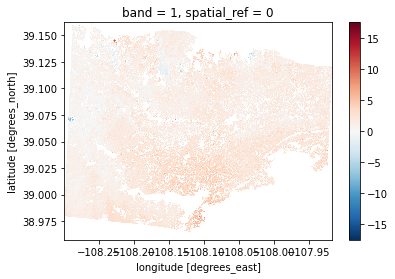

In [31]:
fig, ax = plt.subplots()
#xover.to_crs('epsg:4326').plot()
unw_all.plot()

In [20]:
from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth

In [21]:
os.chdir('/home/jovyan/isce_sat2/contributors/Besso/data')

In [22]:
# Open up our two rasters (unwrapped phase and incidence angle)
#unw = rxa.open_rasterio(join(data_dir, f'unw.tif'))
inc = rxr.open_rasterio('grmesa_27416_20017_006_200312_L090_CX_01.inc.tiff')

# This uses the pytool's function to directly give you snow depth change
# feel free to rerun with this to check your results
# https://github.com/SnowEx/uavsar_pytools/blob/main/uavsar_pytools/snow_depth_inversion.py
sd_change = depth_from_phase(unw_all, inc, density = 200)

# convert to centimeters from meters
sd_change = sd_change*100

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


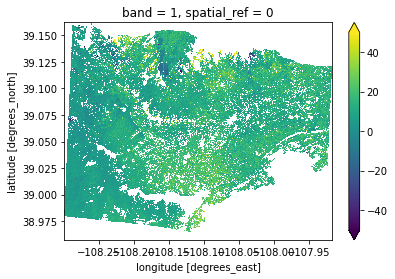

In [55]:
sd_change.plot(vmin=-50, vmax=50)

In [32]:
xover_4326 = xover.to_crs('epsg:4326')

In [34]:
# for index, row in xover_4326.iterrows():
#     xover_4326['points_x'] = row.geometry.centroid.x
#     xover_4326['points_y'] = row.geometry.centroid.y

In [33]:
for index, row in xover_4326.iterrows():
    print(row.geometry.centroid.x)
    print(row.geometry.centroid.y)

-108.09062723254311
39.11387298450202
-108.09062746081611
39.113693301198836


-108.09062723254311
39.11387298450202
-108.09062746081611
39.113693301198836



In [34]:
coord = [(-108.09062723254311, 39.11387298450202), (-108.09062746081611,39.113693301198836)]

In [35]:
def sample_raster(df, src, coord):
    #df_proj = df.to_crs(src.crs)
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    out_colname = sample_colname
    return out_colname

In [36]:
sample_raster(xover, cor_12_19feb, coord)

'grmesa_27416_20005-007_20008-004_0007d_s01_L090VV_01.cor.grd'

In [37]:
sample_raster(xover, cor_19_26feb, coord)

'grmesa_27416_20008-004_20013-004_0007d_s01_L090VV_01.cor.grd'

In [38]:
sample_raster(xover, cor_26_12mar, coord)

'grmesa_27416_20013-004_20017-006_0015d_s01_L090VV_01.cor.grd'

In [39]:
unw_all.rio.to_raster('all_unw.tif')

In [40]:
with rio.open('all_unw.tif') as src:
    sample_raster(xover, src, coord)

In [41]:
inc = rio.open('grmesa_27416_20017_006_200312_L090_CX_01.inc.tiff')

In [42]:
sample_raster(xover,inc,coord)

'grmesa_27416_20017_006_200312_L090_CX_01.inc'

In [21]:
#?phase_from_depth

In [44]:
xover.iloc[0]['xover_diff']

0.7643478185000276

In [45]:
inc_angle = xover.iloc[0]['grmesa_27416_20017_006_200312_L090_CX_01.inc']

In [46]:
inc_angle

0.59354734

In [28]:
phase_from_is2_pt1 = phase_from_depth(xover.iloc[0]['xover_diff'], 
                                  inc_angle = xover.iloc[0]['inc_angle'], 
                                  density=200)
phase_from_is2_pt2 = phase_from_depth(xover.iloc[1]['xover_diff'], 
                                      inc_angle = xover.iloc[1]['inc_angle'], 
                                      density=200)
print(phase_from_is2_pt1)
print(phase_from_is2_pt2)

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
7.32333820810315
2.1069905927027786


In [59]:
phase_from_is2

7.32333820810315

In [57]:
xover

,n_fit_photons_1,dh_fit_dy_1,h_sigma_1,cycle_1,spot_1,rgt_1,segment_id_1,pflags_1,w_surface_window_final_1,dh_fit_dx_1,...,gt_2,confidence_2,acqdate_2,geometry,xover_diff,cor_12-19feb,cor_19-26feb,cor_26-12,all_unw,inc_angle
0,22,0.0,0.056914,6,6,1156,784810,0,3.000000,0.081592,...,20,4,2020-02-12,"POLYGON ((751544.895 4333443.382, 751544.955 4...",0.764348,0.858930,0.810624,0.618839,0.957284,0.593547
1,31,0.0,0.064538,6,6,1156,784811,0,3.429393,0.132330,...,20,4,2020-02-12,"POLYGON ((751544.417 4333424.820, 751544.614 4...",0.224926,0.892194,0.879170,0.473401,1.078139,0.551062


In [52]:
xover

,n_fit_photons_1,dh_fit_dy_1,h_sigma_1,cycle_1,spot_1,rgt_1,segment_id_1,pflags_1,w_surface_window_final_1,dh_fit_dx_1,...,gt_2,confidence_2,acqdate_2,geometry,xover_diff,cor_12-19feb,cor_19-26feb,cor_26-12,all_unw,inc_angle
0,22,0.0,0.056914,6,6,1156,784810,0,3.000000,0.081592,...,20,4,2020-02-12,"POLYGON ((751544.895 4333443.382, 751544.955 4...",0.764348,0.858930,0.810624,0.618839,0.957284,0.593547
1,31,0.0,0.064538,6,6,1156,784811,0,3.429393,0.132330,...,20,4,2020-02-12,"POLYGON ((751544.417 4333424.820, 751544.614 4...",0.224926,0.892194,0.879170,0.473401,1.078139,0.551062


In [51]:
xover = xover.rename(columns={'grmesa_27416_20005-007_20008-004_0007d_s01_L090VV_01.cor.grd':'cor_12-19feb',
                              'grmesa_27416_20008-004_20013-004_0007d_s01_L090VV_01.cor.grd':'cor_19-26feb',
                             'grmesa_27416_20013-004_20017-006_0015d_s01_L090VV_01.cor.grd':'cor_26-12',
                             'grmesa_27416_20017_006_200312_L090_CX_01.inc':'inc_angle'})

In [26]:
out_fp = '../../../data/xover.pkl'

In [54]:
#Only run if ready to save an updated file

# with open(out_fp, 'wb') as f:
#     pickle.dump(xover, f)

In [27]:
xover = pickle.load(open(out_fp, 'rb'))

In [29]:
phase_cor_pt1 = phase_from_is2_pt1 - xover.iloc[0]['all_unw']
phase_cor_pt2 = phase_from_is2_pt2 - xover.iloc[1]['all_unw']
print(phase_cor_pt1)
print(phase_cor_pt2)

6.366054472827882
1.028851168378743


In [33]:
xover

,n_fit_photons_1,dh_fit_dy_1,h_sigma_1,cycle_1,spot_1,rgt_1,segment_id_1,pflags_1,w_surface_window_final_1,dh_fit_dx_1,...,gt_2,confidence_2,acqdate_2,geometry,xover_diff,cor_12-19feb,cor_19-26feb,cor_26-12,all_unw,inc_angle
0,22,0.0,0.056914,6,6,1156,784810,0,3.000000,0.081592,...,20,4,2020-02-12,"POLYGON ((751544.895 4333443.382, 751544.955 4...",0.764348,0.858930,0.810624,0.618839,0.957284,0.593547
1,31,0.0,0.064538,6,6,1156,784811,0,3.429393,0.132330,...,20,4,2020-02-12,"POLYGON ((751544.417 4333424.820, 751544.614 4...",0.224926,0.892194,0.879170,0.473401,1.078139,0.551062


In [30]:
unw_all_corrected1 = unw_all + phase_cor_pt1
unw_all_corrected2 = unw_all + phase_cor_pt2

In [31]:
# Open up our two rasters (unwrapped phase and incidence angle)
#unw = rxa.open_rasterio(join(data_dir, f'unw.tif'))
#inc = rxr.open_rasterio('grmesa_27416_20017_006_200312_L090_CX_01.inc.tiff')

# This uses the pytool's function to directly give you snow depth change
# feel free to rerun with this to check your results
# https://github.com/SnowEx/uavsar_pytools/blob/main/uavsar_pytools/snow_depth_inversion.py
sd_change_corrected1 = depth_from_phase(unw_all_corrected1, inc, density = 200)

# convert to centimeters from meters
sd_change_corrected1 = sd_change_corrected1*100

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


In [32]:
sd_change_corrected2 = depth_from_phase(unw_all_corrected2, inc, density = 200)

# convert to centimeters from meters
sd_change_corrected2 = sd_change_corrected2*100

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


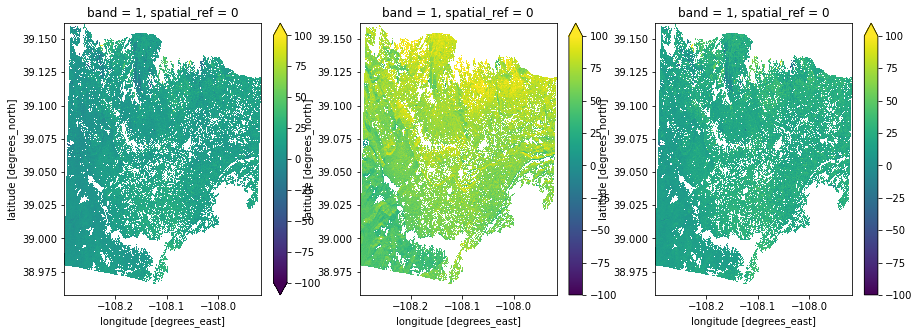

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sd_change.plot(ax=ax[0], vmin=-100, vmax=100)
sd_change_corrected1.plot(ax=ax[1], vmin=-100, vmax=100)
sd_change_corrected2.plot(ax=ax[2], vmin=-100, vmax=100)
#gm_poly.plot(facecolor='none')

## Now do the same thing but with the SNOTEL site.

In [33]:
out_fp = '../../../data/snotel_locations.pkl'

In [34]:
sntl_gdf = pickle.load(open(out_fp, 'rb'))

In [35]:
sntl_sd = pickle.load(open('../../../data/snotel_depths.pkl', 'rb'))

In [114]:
sntl_sd.head()

,MesaLakes,ParkReservoir
Date,,
2018-10-01 00:00:00,0.0,NaN
2018-10-02 00:00:00,0.0,NaN
2018-10-03 00:00:00,0.0,NaN
2018-10-04 00:00:00,0.0,NaN
2018-10-05 00:00:00,0.0,NaN


In [60]:
sntl_gdf

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
0,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000)
1,07K06S,1978-10-01,Delta,2100-01-01,US,029,08,140200050111,14020005,Park Reservoir,PRVC2,-8.0,None,682:CO:SNTL,POINT Z (-107.87951 39.04433 9987.00000)


In [36]:
def sample_raster(df, src, diff_col=None):
    #df_proj = df.to_crs(src.crs)
    coord = [(pt.x, pt.y) for pt in df.to_crs(src.crs).geometry]
    s = np.fromiter(src.sample(coord), dtype=src.dtypes[0])
    #s[s == src.nodata] = np.nan
    sm = np.ma.masked_equal(s, src.nodata)
    sample_colname = os.path.splitext(os.path.split(src.name)[-1])[0]
    df[sample_colname] = sm
    if diff_col is not None:
        out_colname = '{} {} diff'.format(diff_col, sample_colname)
        df[out_colname] = df[diff_col] - df[sample_colname]
    else:
        out_colname = sample_colname
    return out_colname

In [48]:
sample_raster(sntl_gdf, cor_12_19feb)

'grmesa_27416_20005-007_20008-004_0007d_s01_L090VV_01.cor.grd'

In [49]:
sample_raster(sntl_gdf, cor_19_26feb)

'grmesa_27416_20008-004_20013-004_0007d_s01_L090VV_01.cor.grd'

In [50]:
sample_raster(sntl_gdf, cor_26_12mar)

'grmesa_27416_20013-004_20017-006_0015d_s01_L090VV_01.cor.grd'

In [51]:
unw_all.rio.to_raster('all_unw.tif')

In [52]:
with rio.open('all_unw.tif') as src:
    sample_raster(sntl_gdf, src)

In [43]:
inc = rio.open('grmesa_27416_20017_006_200312_L090_CX_01.inc.tiff')

In [44]:
sample_raster(sntl_gdf,inc)

'grmesa_27416_20017_006_200312_L090_CX_01.inc'

In [45]:
sntl_gdf = sntl_gdf.rename(columns={'grmesa_27416_20005-007_20008-004_0007d_s01_L090VV_01.cor.grd':'cor_12-19feb',
                              'grmesa_27416_20008-004_20013-004_0007d_s01_L090VV_01.cor.grd':'cor_19-26feb',
                             'grmesa_27416_20013-004_20017-006_0015d_s01_L090VV_01.cor.grd':'cor_26-12',
                             'grmesa_27416_20017_006_200312_L090_CX_01.inc':'inc_angle'})

In [56]:
sntl_gdf

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry,cor_12-19feb,cor_19-26feb,cor_26-12,all_unw,inc_angle
0,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000),0.547047,0.50773,0.156083,1.572386,1.018035
1,07K06S,1978-10-01,Delta,2100-01-01,US,029,08,140200050111,14020005,Park Reservoir,PRVC2,-8.0,None,682:CO:SNTL,POINT Z (-107.87951 39.04433 9987.00000),0.000000,NaN,NaN,0.000000,NaN


In [57]:
out_fp = '../../../snotel_locations_sar.pkl'

In [53]:
with open(out_fp, 'wb') as f:
    pickle.dump(sntl_gdf, f)

In [54]:
sntl_gdf = pickle.load(open(out_fp, 'rb'))

In [134]:
sntl_sd.tail()

,MesaLakes,ParkReservoir
2022-07-11,NaN,35.56
2022-07-12,NaN,35.56
2022-07-13,NaN,35.56
2022-07-14,NaN,35.56
2022-07-15,NaN,35.56


In [38]:
import datetime

In [39]:
sntl_sd.index = pd.to_datetime(sntl_sd.index)

In [40]:
sntl_sd.index = sntl_sd.index.date

In [41]:
sntl_sd_ml = 0.0001
sntl_sd_pr = 129.54 - 132.08

(18293.0, 18351.0)

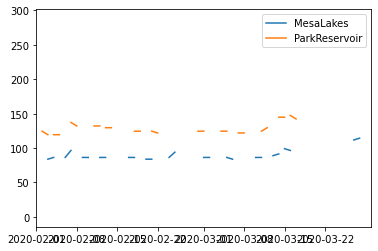

In [126]:
fig, ax = plt.subplots()
sntl_sd.plot(ax=ax)
ax.set_xlim(datetime.date(2020,2,1), datetime.date(2020,3,30))

In [48]:
phase_from_sntl_pt1 = phase_from_depth(sntl_sd_ml, 
                                  inc_angle = sntl_gdf.iloc[0]['inc_angle'], 
                                  density=200)
phase_from_sntl_pt2 = phase_from_depth(sntl_sd_pr, 
                                      inc_angle = sntl_gdf.iloc[1]['inc_angle'], 
                                      density=200)
print(phase_from_sntl_pt1)
print(phase_from_sntl_pt2)

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.
0.0013495371789029077
nan


/srv/conda/envs/notebook/lib/python3.10/site-packages/uavsar_pytools/snow_depth_inversion.py:134: RuntimeWarning: Mean of empty slice
  if np.nanmean(inc_angle) > 2*np.pi:


In [50]:
sntl_gdf

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry,inc_angle
0,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000),1.018035
1,07K06S,1978-10-01,Delta,2100-01-01,US,029,08,140200050111,14020005,Park Reservoir,PRVC2,-8.0,None,682:CO:SNTL,POINT Z (-107.87951 39.04433 9987.00000),NaN


In [55]:
phase_cor_pt1_sntl = 0 - sntl_gdf.iloc[0]['all_unw']
#phase_cor_pt2_sntl = phase_from_sntl_pt2 - sntl_gdf.iloc[1]['all_unw']
print(phase_cor_pt1_sntl)
#print(phase_cor_pt2_sntl)

-1.5723862648010254


In [56]:
all_unw_cor_sntl = unw_all - phase_cor_pt1_sntl

In [57]:
inc = rxr.open_rasterio('grmesa_27416_20017_006_200312_L090_CX_01.inc.tiff')
sd_change_corrected_sntl = depth_from_phase(all_unw_cor_sntl, inc, density = 200)

# convert to centimeters from meters
sd_change_corrected_sntl = sd_change_corrected_sntl*100

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


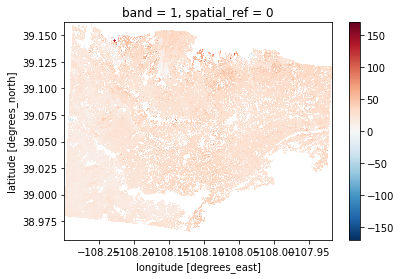

In [160]:
sd_change_corrected_sntl.plot()

In [63]:
import contextily as cx
basemap = cx.providers.Stamen.Terrain

In [65]:
!pwd

/home/jovyan/isce_sat2/contributors/Besso/data


/srv/conda/envs/notebook/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


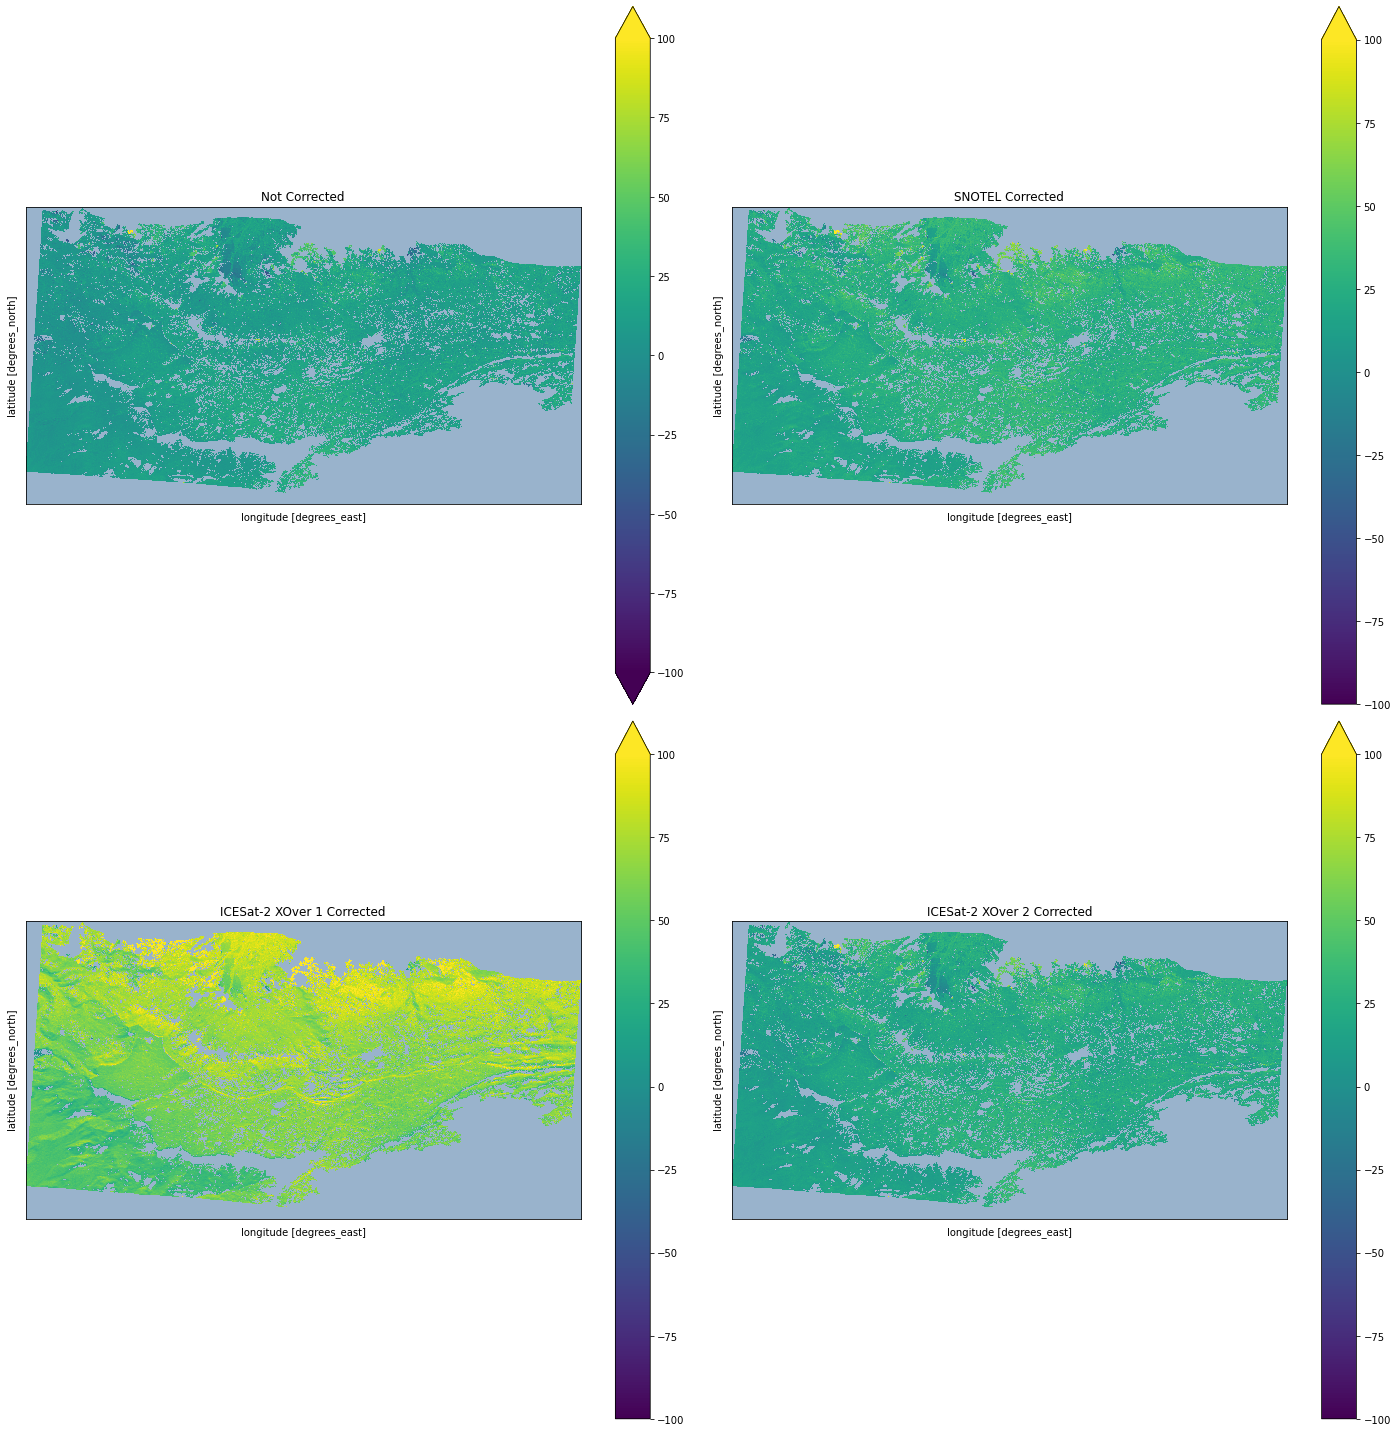

In [64]:
fig, axa = plt.subplots(2,2, figsize=(20,20))

sd_change.plot(ax=axa[0,0], vmin=-100, vmax=100)
sd_change_corrected_sntl.plot(ax=axa[0,1], vmin=-100, vmax=100)
sd_change_corrected1.plot(ax=axa[1,0], vmin=-100, vmax=100)
sd_change_corrected2.plot(ax=axa[1,1], vmin=-100, vmax=100)

#gm_poly.plot(facecolor='none')

#for ax in axa:
    #ax.add_artist(ScaleBar(1))
cx.add_basemap(axa[0,0], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
cx.add_basemap(axa[1,0], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
cx.add_basemap(axa[0,1], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
cx.add_basemap(axa[1,1], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
axa[0,0].axes.xaxis.set_ticks([])
axa[1,0].axes.xaxis.set_ticks([])
axa[0,1].axes.xaxis.set_ticks([])
axa[1,1].axes.xaxis.set_ticks([])
axa[0,0].axes.yaxis.set_ticks([])
axa[1,0].axes.yaxis.set_ticks([])
axa[0,1].axes.yaxis.set_ticks([])
axa[1,1].axes.yaxis.set_ticks([])
    
axa[0,0].set_title('Not Corrected')
axa[0,1].set_title('SNOTEL Corrected')
axa[1,0].set_title('ICESat-2 XOver 1 Corrected')
axa[1,1].set_title('ICESat-2 XOver 2 Corrected')

plt.tight_layout()
plt.savefig('sn_change_corrected.jpeg', dpi=500)

## Compare to pits

In [82]:
out_fp = '../../../data/snowdepthchange_feb12mar12.pkl'

In [83]:
sd_pits = pickle.load(open(out_fp, 'rb'))

In [86]:
sd_pits.head()

,site_name_1,date_1,time_created_1,time_updated_1,id_1,doi_1,date_accessed_1,instrument_1,type_1,units_1,...,easting_2,elevation_2,utm_zone_2,time_2,site_id_2,version_number_2,equipment_2,value_2,geometry,sd_diff
0,Grand Mesa,2020-02-11,2022-06-30 22:58:59.800562+00:00,None,44302,None,2022-06-30,camera,depth,cm,...,249756.705396,NaN,13,18:00:00+00:00,None,NaN,camera id = E9C,80.92719,POINT (-113.89370 39.09896),-12.20508
1,Grand Mesa,2020-02-11,2022-06-30 22:58:59.800562+00:00,None,44303,None,2022-06-30,camera,depth,cm,...,249756.705396,NaN,13,18:00:00+00:00,None,NaN,camera id = E9C,80.92719,POINT (-113.89370 39.09896),-9.49284
2,Grand Mesa,2020-02-11,2022-06-30 22:58:59.800562+00:00,None,44304,None,2022-06-30,camera,depth,cm,...,249756.705396,NaN,13,18:00:00+00:00,None,NaN,camera id = E9C,80.92719,POINT (-113.89370 39.09896),-8.58876
3,Grand Mesa,2020-02-12,2022-06-30 22:58:59.800562+00:00,None,44305,None,2022-06-30,camera,depth,cm,...,249756.705396,NaN,13,18:00:00+00:00,None,NaN,camera id = E9C,80.92719,POINT (-113.89370 39.09896),-11.30100
4,Grand Mesa,2020-02-12,2022-06-30 22:58:59.800562+00:00,None,44306,None,2022-06-30,camera,depth,cm,...,249756.705396,NaN,13,18:00:00+00:00,None,NaN,camera id = E9C,80.92719,POINT (-113.89370 39.09896),-9.04080


In [ ]:
with rio.open('sd_change_corrected2.tif') as src:
    sample_raster(sntl_gdf, src)

In [87]:
sample_raster(sd_pits, sd_change_corrected2, 'sd_diff')

AttributeError: 'DataArray' object has no attribute 'crs'